    #### INITIAL DISTRIBUTION: TWO MODES ####
    θ_v_1 = 1000.0
    N_1   = 10.0
    k_1   = 4
    θ_v_2 = 200.0
    N_2   = 100.0
    k_2   = 2

## PySDM

In [1]:
import sys, os
os.environ["NUMBA_DISABLE_JIT"] = "1"

import numpy as np

from PySDM.backends import CPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Collision
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity, UniformRandom

from PySDM.products.size_spectral import ParticleVolumeVersusRadiusLogarithmSpectrum, ParticleSizeSpectrumPerVolume
import PySDM.products.size_spectral.arbitrary_moment as am
from PySDM.products.housekeeping.timers import WallTime

from matplotlib import pyplot

from PySDM.initialisation.spectra import Gamma, Exponential, Sum
from PySDM.dynamics.collisions.collision_kernels import ConstantK, Golovin
from PySDM.dynamics.collisions.coalescence_efficiencies import ConstEc
from PySDM.dynamics.collisions.breakup_efficiencies import ConstEb
from PySDM.dynamics.collisions.breakup_fragmentations import AlwaysN
from PySDM.physics.constants import si
from PySDM.physics.constants_defaults import rho_w, rho_STP
from PySDM import Formulae
from pystrict import strict

from numba import config, threading_layer
config.THREADING_LAYER = 'default'

from scipy.stats import gamma

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (idx, array[idx])

In [3]:
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**15
        self.dv = 1 * si.m**3

        self.n_part1 = 10 / si.cm**3
        self.k1 = 4
        self.theta1 = 1000 * si.um**3
        self.n_part2 = 100 / si.cm**3
        self.k2 = 2
        self.theta2 = 200 * si.um**3
        
        self.norm_factor1 = self.n_part1 * self.dv
        self.norm_factor2 = self.n_part2 * self.dv
        self.spectrum1 = Gamma(norm_factor=self.norm_factor1, theta=self.theta1, k=self.k1)
        self.spectrum2 = Gamma(norm_factor=self.norm_factor2, theta=self.theta2, k=self.k2)
        self.spectrum = Sum((self.spectrum1, self.spectrum2))

        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 600 * si.seconds
        self.adaptive = False
        self.seed = 44
        self._steps = [0, 4*3600.0]
        self.kernel = Golovin(b=1500 / si.second)
        self.coal_eff = ConstEc(Ec=1.0)
        self.fragmentation = AlwaysN(n=1)
        self.break_eff = ConstEb(0.0) # no "bouncing"
        
        self.radius_bins_edges = np.logspace(np.log10(1 * si.um), np.log10(1000 * si.um), num=128, endpoint=True)
        self.volume_bins_edges = self.radius_bins_edges**3 * 4 * np.pi / 3
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

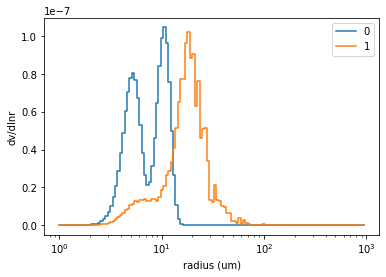

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
# env['rhod'] = 1
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
products = [dvdlnr, nv]
core = builder.build(attributes, products)
sdm_y = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_y1 = np.zeros((len(settings.radius_bins_edges)-1,len(settings.output_steps)))
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
i = 0
v_cutoff = 1e3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]
dr = settings.radius_bins_edges[1:] - settings.radius_bins_edges[:-1]
for step in settings.output_steps:
    core.run(step - core.n_steps)
    sdm_y[:,i] = core.products['N(v)'].get() * si.cm**3 * dr
    sdm_y1[:,i] = core.products['dv/dlnr'].get()[0]
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.um, 
            y=sdm_y1[:,i],
            where='post', label="t = {step*settings.dt}s")
    i += 1
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dv/dlnr")
pyplot.legend([0, 1, 2])
#pyplot.xlim([1e1, 1e6])

In [5]:
dlnr = np.mean(np.log(settings.radius_bins_edges[1:]) - np.log(settings.radius_bins_edges[:-1]))

In [6]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend(settings.formulae))
env = Box(dv=settings.dv, dt=settings.dt)
builder.set_environment(env)
env['rhod'] = 1.00 * si.kg / si.m**3
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd) #UniformRandom(settings.spectrum).sample(settings.n_sd)
breakup = Collision(collision_kernel = settings.kernel, coalescence_efficiency=settings.coal_eff, breakup_efficiency=settings.break_eff, 
    fragmentation_function=settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)

M0 = am.make_arbitrary_moment_product(rank=0, attr='volume', attr_unit='dimensionless')(name='M0')
M1 = am.make_arbitrary_moment_product(rank=1, attr='volume', attr_unit='m^3')(name='M1')
M2 = am.make_arbitrary_moment_product(rank=2, attr='volume', attr_unit='m^6')(name='M2')
Nv = ParticleSizeSpectrumPerVolume(radius_bins_edges=settings.radius_bins_edges, name='N(v)')
dvdlnr = ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=settings.radius_bins_edges, name='dv/dlnr')
products = [M0, M1, M2, Nv, dvdlnr]
core = builder.build(attributes, products)
sdm_x = settings.radius_bins_edges[:-1]**3 * 4 * np.pi / 3 / si.um**3
dx_sdm = np.diff(np.append([0.0], sdm_x))

r_cutoff = 25
v_cutoff = 4/3*np.pi*r_cutoff**3
bin_cutoff = find_nearest(sdm_x, v_cutoff)[0]

mom0 = np.zeros(int(settings._steps[-1]/settings.dt))
mom1 = np.zeros(int(settings._steps[-1]/settings.dt))
mom2 = np.zeros(int(settings._steps[-1]/settings.dt))
sdm_precip = np.zeros(int(settings._steps[-1]/settings.dt))
i = 0
for step in range(int(settings._steps[-1]/settings.dt)):
    core.run(step - core.n_steps)
    mom0[i] = M0.get()
    mom1[i] = M1.get() 
    mom2[i] = M2.get()
    dvdlnr_instant = core.products['dv/dlnr'].get()[0] * si.cm**3 / si.um**3
    mv_instant = dvdlnr_instant*dlnr

    sdm_precip[i] = np.sum(mv_instant[bin_cutoff:])
    i += 1
times_sdm = range(0,int(settings._steps[-1]),int(settings.dt))


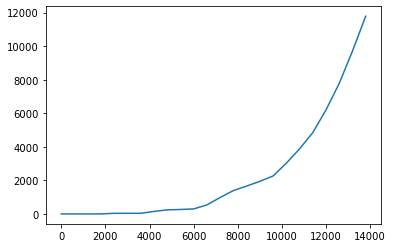

In [7]:
pyplot.plot(times_sdm, sdm_precip)

## Bin

In [8]:
# golovin_bimodal
# Tmax, nbin, dt, scal, emin, rhow, B, k1, theta, N0 
# [14400.0, 32, 5.0, 1, 7.091336e-10, 1e-09, 1.5e-09, 4, 1000, 10]

v_grid = [1.06370040e+00, 2.12740080e+00, 4.25480160e+00, 8.50960320e+00,
 1.70192064e+01, 3.40384128e+01, 6.80768256e+01, 1.36153651e+02,
 2.72307302e+02, 5.44614605e+02, 1.08922921e+03, 2.17845842e+03,
 4.35691684e+03, 8.71383368e+03, 1.74276674e+04, 3.48553347e+04,
 6.97106694e+04, 1.39421339e+05, 2.78842678e+05, 5.57685355e+05,
 1.11537071e+06, 2.23074142e+06, 4.46148284e+06, 8.92296569e+06,
 1.78459314e+07, 3.56918627e+07, 7.13837255e+07, 1.42767451e+08,
 2.85534902e+08, 5.71069804e+08, 1.14213961e+09, 2.28427922e+09]
r_grid = [6.33252487e-01, 7.97848139e-01, 1.00522566e+00, 1.26650497e+00,
 1.59569628e+00, 2.01045133e+00, 2.53300995e+00, 3.19139256e+00,
 4.02090266e+00, 5.06601990e+00, 6.38278511e+00, 8.04180532e+00,
 1.01320398e+01, 1.27655702e+01, 1.60836106e+01, 2.02640796e+01,
 2.55311404e+01, 3.21672213e+01, 4.05281592e+01, 5.10622809e+01,
 6.43344425e+01, 8.10563184e+01, 1.02124562e+02, 1.28668885e+02,
 1.62112637e+02, 2.04249124e+02, 2.57337770e+02, 3.24225274e+02,
 4.08498247e+02, 5.14675540e+02, 6.48450547e+02, 8.16996494e+02]

gr0 = [8.97861677e-003, 7.14479261e-002, 5.65535701e-001, 4.42905267e+000,
 3.39564697e+001, 2.49491685e+002, 1.68358081e+003, 9.58306636e+003,
 3.88146017e+004, 7.97023963e+004, 4.43805294e+004, 2.92153418e+004,
 1.00619543e+005, 4.12711389e+004, 2.16983420e+002, 1.87428989e-004,
 4.37025938e-018, 7.42502868e-047, 6.69776647e-106, 1.70311414e-225,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
 0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]
gr36 = [5.67386494e-03, 4.51270801e-02, 3.56809168e-01, 2.78832721e+00,
 2.12848548e+01, 1.55041344e+02, 1.02855910e+03, 5.67260242e+03,
 2.20058659e+04, 4.66238875e+04, 3.88433013e+04, 2.59972949e+04,
 7.39893307e+04, 8.10643641e+04, 4.07853362e+04, 8.89837367e+03,
 6.70930699e+02, 1.61855620e+01, 1.50568610e-01, 7.22989705e-04,
 1.40907971e-06, 8.73823627e-13, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
gr144 = [1.43323018e-03, 1.13915634e-02, 8.99423166e-02, 7.00867549e-01,
 5.31977281e+00, 3.83130720e+01, 2.48563033e+02, 1.31517253e+03,
 4.80852940e+03, 1.02088210e+04, 1.14359876e+04, 9.15186843e+03,
 1.81760158e+04, 3.05784287e+04, 4.38101706e+04, 5.70412752e+04,
 6.42426324e+04, 5.53606242e+04, 3.00823256e+04, 8.24917960e+03,
 9.70926598e+02, 4.93945115e+01, 1.33001149e+00, 2.34450300e-02,
 2.23550397e-04, 2.47959763e-11, 0.00000000e+00, 0.00000000e+00,
 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]
t_bott = [    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,   800.,
   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,  1600.,  1700.,
  1800.,  1900.,  2000.,  2100.,  2200.,  2300.,  2400.,  2500.,  2600.,
  2700.,  2800.,  2900.,  3000.,  3100.,  3200.,  3300.,  3400.,  3500.,
  3600.,  3700.,  3800.,  3900.,  4000.,  4100.,  4200.,  4300.,  4400.,
  4500.,  4600.,  4700.,  4800.,  4900.,  5000.,  5100.,  5200.,  5300.,
  5400.,  5500.,  5600.,  5700.,  5800.,  5900.,  6000.,  6100.,  6200.,
  6300.,  6400.,  6500.,  6600.,  6700.,  6800.,  6900.,  7000.,  7100.,
  7200.,  7300.,  7400.,  7500.,  7600.,  7700.,  7800.,  7900.,  8000.,
  8100.,  8200.,  8300.,  8400.,  8500.,  8600.,  8700.,  8800.,  8900.,
  9000.,  9100.,  9200.,  9300.,  9400.,  9500.,  9600.,  9700.,  9800.,
  9900., 10000., 10100., 10200., 10300., 10400., 10500., 10600., 10700.,
 10800., 10900., 11000., 11100., 11200., 11300., 11400., 11500., 11600.,
 11700., 11800., 11900., 12000., 12100., 12200., 12300., 12400., 12500.,
 12600., 12700., 12800., 12900., 13000., 13100., 13200., 13300., 13400.,
 13500., 13600., 13700., 13800., 13900., 14000., 14100., 14200., 14300.,
 14400.]
M0_bott = [109.98399358, 108.65293658, 107.33701538, 106.0361858 , 104.75034419,
 103.47936605, 102.22311709, 100.98145783,  99.7542459 ,  98.54133736,
  97.34258743,  96.1578511 ,  94.98698339,  93.82983967,  92.6862758 ,
  91.55614831,  90.43931445,  89.33563231,  88.24496088,  87.16716009,
  86.10209084,  85.04961507,  84.00959574,  82.9818969 ,  81.96638367,
  80.96292224,  79.97137996,  78.99162526,  78.02352769,  77.06695796,
  76.12178788,  75.18789042,  74.26513968,  73.35341091,  72.45258048,
  71.56252592,  70.68312589,  69.8142602 ,  68.95580977,  68.10765668,
  67.26968413,  66.44177645,  65.62381907,  64.81569858,  64.01730265,
  63.22852008,  62.44924076,  61.67935569,  60.91875695,  60.16733772,
  59.42499227,  58.69161592,  57.96710508,  57.25135721,  56.54427083,
  55.84574553,  55.15568191,  54.47398161,  53.80054733,  53.13528277,
  52.47809262,  51.82888263,  51.1875595 ,  50.55403096,  49.92820569,
  49.30999337,  48.69930466,  48.09605114,  47.50014539,  46.91150091,
  46.33003214,  45.75565446,  45.18828417,  44.62783849,  44.07423553,
  43.52739431,  42.98723475,  42.45367764,  41.92664466,  41.40605835,
  40.8918421 ,  40.38392018,  39.88221767,  39.38666052,  38.89717548,
  38.41369015,  37.93613291,  37.46443299,  36.99852037,  36.53832585,
  36.083781  ,  35.63481819,  35.19137052,  34.75337187,  34.32075689,
  33.89346093,  33.47142013,  33.05457131,  32.64285206,  32.23620065,
  31.83455608,  31.43785803,  31.0460469 ,  30.65906377,  30.27685037,
  29.89934916,  29.5265032 ,  29.15825626,  28.79455275,  28.4353377 ,
  28.08055682,  27.73015641,  27.38408342,  27.04228541,  26.70471057,
  26.37130766,  26.04202607,  25.71681576,  25.3956273 ,  25.07841182,
  24.76512103,  24.45570721,  24.1501232 ,  23.84832238,  23.5502587 ,
  23.25588664,  22.96516124,  22.67803802,  22.39447309,  22.11442303,
  21.83784495,  21.56469647,  21.29493571,  21.02852129,  20.76541231,
  20.50556838,  20.24894956,  19.99551641,  19.74522994,  19.49805164,
  19.25394344,  19.01286775,  18.7747874 ,  18.53966569,  18.30746634]
M1_bott = [79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176049,
 79891.15176049, 79891.15176049, 79891.15176049, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048, 79891.15176048, 79891.15176048, 79891.15176048,
 79891.15176048]
M2_bott = [2.23930994e+08, 2.28881227e+08, 2.34002627e+08, 2.39281863e+08,
 2.44714499e+08, 2.50299266e+08, 2.56036467e+08, 2.61927328e+08,
 2.67973688e+08, 2.74177817e+08, 2.80542326e+08, 2.87070093e+08,
 2.93764225e+08, 3.00628033e+08, 3.07665005e+08, 3.14878799e+08,
 3.22273227e+08, 3.29852254e+08, 3.37619988e+08, 3.45580680e+08,
 3.53738717e+08, 3.62098626e+08, 3.70665071e+08, 3.79442853e+08,
 3.88436908e+08, 3.97652312e+08, 4.07094281e+08, 4.16768170e+08,
 4.26679479e+08, 4.36833849e+08, 4.47237074e+08, 4.57895093e+08,
 4.68814000e+08, 4.80000044e+08, 4.91459635e+08, 5.03199342e+08,
 5.15225903e+08, 5.27546224e+08, 5.40167385e+08, 5.53096642e+08,
 5.66341435e+08, 5.79909387e+08, 5.93808312e+08, 6.08046219e+08,
 6.22631314e+08, 6.37572009e+08, 6.52876921e+08, 6.68554884e+08,
 6.84614947e+08, 7.01066384e+08, 7.17918697e+08, 7.35181621e+08,
 7.52865133e+08, 7.70979452e+08, 7.89535052e+08, 8.08542660e+08,
 8.28013269e+08, 8.47958141e+08, 8.68388814e+08, 8.89317109e+08,
 9.10755137e+08, 9.32715304e+08, 9.55210324e+08, 9.78253218e+08,
 1.00185733e+09, 1.02603633e+09, 1.05080421e+09, 1.07617534e+09,
 1.10216439e+09, 1.12878645e+09, 1.15605692e+09, 1.18399161e+09,
 1.21260673e+09, 1.24191884e+09, 1.27194496e+09, 1.30270248e+09,
 1.33420924e+09, 1.36648352e+09, 1.39954404e+09, 1.43340996e+09,
 1.46810093e+09, 1.50363709e+09, 1.54003904e+09, 1.57732791e+09,
 1.61552533e+09, 1.65465347e+09, 1.69473504e+09, 1.73579330e+09,
 1.77785209e+09, 1.82093581e+09, 1.86506949e+09, 1.91027873e+09,
 1.95658980e+09, 2.00402957e+09, 2.05262561e+09, 2.10240613e+09,
 2.15340005e+09, 2.20563697e+09, 2.25914726e+09, 2.31396199e+09,
 2.37011301e+09, 2.42763295e+09, 2.48655522e+09, 2.54691406e+09,
 2.60874455e+09, 2.67208262e+09, 2.73696509e+09, 2.80342966e+09,
 2.87151496e+09, 2.94126058e+09, 3.01270706e+09, 3.08589593e+09,
 3.16086974e+09, 3.23767208e+09, 3.31634760e+09, 3.39694206e+09,
 3.47950232e+09, 3.56407639e+09, 3.65071345e+09, 3.73946389e+09,
 3.83037934e+09, 3.92351266e+09, 4.01891804e+09, 4.11665097e+09,
 4.21676831e+09, 4.31932831e+09, 4.42439064e+09, 4.53201642e+09,
 4.64226828e+09, 4.75521038e+09, 4.87090844e+09, 4.98942979e+09,
 5.11084341e+09, 5.23521996e+09, 5.36263183e+09, 5.49315318e+09,
 5.62685998e+09, 5.76383007e+09, 5.90414318e+09, 6.04788098e+09,
 6.19512717e+09, 6.34596745e+09, 6.50048966e+09, 6.65878376e+09,
 6.82094191e+09]
mprecip_bin = [1.71554590e-47, 2.15666302e-09, 7.51674721e-08, 6.52438092e-07,
 3.18021093e-06, 1.12253607e-05, 3.21810723e-05, 7.97311861e-05,
 1.77255564e-04, 3.62384490e-04, 6.92936157e-04, 1.25449900e-03,
 2.16994956e-03, 3.61122620e-03, 5.81370982e-03, 9.09359196e-03,
 1.38686435e-02, 2.06828239e-02, 3.02352005e-02, 4.34136735e-02,
 6.13340258e-02, 8.53848345e-02, 1.17278800e-01, 1.59111055e-01,
 2.13425023e-01, 2.83286389e-01, 3.72365742e-01, 4.85030410e-01,
 6.26446013e-01, 8.02688180e-01, 1.02086485e+00, 1.28924953e+00,
 1.61742570e+00, 2.01644274e+00, 2.49898322e+00, 3.07954172e+00,
 3.77461501e+00, 4.60290316e+00, 5.58552138e+00, 6.74622183e+00,
 8.11162469e+00, 9.71145758e+00, 1.15788023e+01, 1.37503477e+01,
 1.62666463e+01, 1.91723751e+01, 2.25165963e+01, 2.63530179e+01,
 3.07402504e+01, 3.57420594e+01, 4.14276091e+01, 4.78716967e+01,
 5.51549734e+01, 6.33641495e+01, 7.25921821e+01, 8.29384410e+01,
 9.45088512e+01, 1.07416009e+02, 1.21779270e+02, 1.37724801e+02,
 1.55385607e+02, 1.74901515e+02, 1.96419117e+02, 2.20091687e+02,
 2.46079040e+02, 2.74547362e+02, 3.05668990e+02, 3.39622148e+02,
 3.76590646e+02, 4.16763527e+02, 4.60334677e+02, 5.07502393e+02,
 5.58468904e+02, 6.13439863e+02, 6.72623794e+02, 7.36231512e+02,
 8.04475502e+02, 8.77569284e+02, 9.55726736e+02, 1.03916141e+03,
 1.12808583e+03, 1.22271076e+03, 1.32324448e+03, 1.42989206e+03,
 1.54285463e+03, 1.66232861e+03, 1.78850505e+03, 1.92156889e+03,
 2.06169825e+03, 2.20906380e+03, 2.36382809e+03, 2.52614494e+03,
 2.69615887e+03, 2.87400452e+03, 3.05980619e+03, 3.25367732e+03,
 3.45572011e+03, 3.66602511e+03, 3.88467094e+03, 4.11172393e+03,
 4.34723795e+03, 4.59125421e+03, 4.84380114e+03, 5.10489428e+03,
 5.37453625e+03, 5.65271683e+03, 5.93941292e+03, 6.23458875e+03,
 6.53819597e+03, 6.85017389e+03, 7.17044969e+03, 7.49893873e+03,
 7.83554484e+03, 8.18016068e+03, 8.53266811e+03, 8.89293863e+03,
 9.26083376e+03, 9.63620556e+03, 1.00188971e+04, 1.04087428e+04,
 1.08055692e+04, 1.12091954e+04, 1.16194334e+04, 1.20360887e+04,
 1.24589612e+04, 1.28878452e+04, 1.33225303e+04, 1.37628018e+04,
 1.42084412e+04, 1.46592267e+04, 1.51149341e+04, 1.55753367e+04,
 1.60402061e+04, 1.65093128e+04, 1.69824264e+04, 1.74593162e+04,
 1.79397515e+04, 1.84235022e+04, 1.89103391e+04, 1.94000342e+04,
 1.98923612e+04, 2.03870956e+04, 2.08840153e+04, 2.13829008e+04,
 2.18835354e+04]


In [9]:
gr_0 = np.array(gr0)
gr_f = np.array(gr144) # um**3/cm3
r_grid = np.array(r_grid)
r_grid = np.insert(r_grid, 0, 0.0)

In [10]:
v_grid_plt = np.array(v_grid)*np.sqrt(2)
r_grid_plt = (v_grid_plt / 4 / np.pi * 3)**(1/3)

## Cloudy

In [11]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def cslogrbf1(x, mean, stddev):
    r = abs((np.log(x)-mean)/stddev)
    cslogr = np.zeros(len(x))
    for (i, ri) in enumerate(r):
        if (ri < 1):
            cslogr[i] = 12/35*(1-ri)**4 * (4+16*ri+12*ri**2+3*ri**3)/x[i]/stddev
    return cslogr

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*cslogrbf1(x, means[i], stddev[i])
        
    return pdf_result

def rbf8_i(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_init = [0.0, 105.3779757505876, 0.001228498822910961, 0.00032239470810806886, 0.0007031987720132858, 0.00021949775901025553, 5.268553865589344e-5, 3.5808625294069276e-5]
    return rbf_basis(x, c_init, means, stddevs)

def rbf8_f(x):
    means = [3.511853499981017, 5.485497865404485, 7.459142230827953, 9.43278659625142, 11.40643096167489, 13.380075327098357, 15.353719692521825, 17.327364057945292]
    stddevs = [5.485497865404485, 5.485497865404485, 3.947288730846936, 3.9472887308469353, 3.947288730846936, 3.947288730846937, 3.9472887308469353, 3.9472887308469353]
    c_final = [0.020887419500399147, 0.48252466108568537, 0.021886393028563746, 0.02397641151030027, 0.0, 0.05013752007754961, 0.0021745535222982347, 0.0]
    return rbf_basis(x, c_final, means, stddevs)

def rbf16_i(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_init = [0.0, 13.557564545039192, 35.48293522152489, 54.334589421965106, 3.7538389358707775e-7, 8.128957568491646, 0.49558793735398804, 4.247610703088978e-6, 5.8983956558722425e-6, 5.947718337922552e-6, 5.185257774273789e-6, 3.4040766897221995e-6, 1.6963320561831901e-6, 6.972178630826224e-7, 3.0913281255195515e-7, 3.6896604493650604e-7]
    return rbf_basis(x, c_init, means, stddevs)

def rbf16_f(x):
    means = [3.511853499981017, 4.432887537178635, 5.353921574376254, 6.274955611573872, 7.195989648771491, 8.117023685969109, 9.038057723166727, 9.959091760364345, 10.880125797561965, 11.801159834759583, 12.7221938719572, 13.643227909154819, 14.564261946352437, 15.485295983550056, 16.406330020747674, 17.327364057945292]
    stddevs = [4.432887537178635, 4.432887537178635, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395237, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236, 1.842068074395236, 1.842068074395236, 1.8420680743952378, 1.8420680743952378, 1.842068074395236]
    c_final = [0.0, 2.192665740156792, 4.8988468214679, 5.673537337389669, 2.477189564127786, 1.2876064472188342, 0.8694306114784089, 0.5432504898675528, 0.37095816458129255, 0.14188579952681357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return rbf_basis(x, c_final, means, stddevs)
    
#import cloudy from julia setup
# GAMMA CASE
# initial moments: 110.0, 8e4, 2.24e8
# k theta = 727; k(k+1)*theta^2 = 2e6; (k+1)*theta = 2750; 727(k+1) = 2750 k;
# initial N, k, theta = 110.0, 2.78, 261.5
# final N, k, theta = 19.540326695818834, 0.0483719736808008, 84637.79853482361, 
def mom_f(x):
    n = 19.540326695818834
    k = 0.0483719736808008
    theta = 84637.79853482361
    return n*gamma.pdf(x, k, scale=theta)
def mom_i(x):
    n =110.0
    k =2.78
    theta = 261.5
    return n*gamma.pdf(x, k, scale=theta)

In [12]:
col_8_times = [0.0, 0.1655430991319866, 0.3539649509046502, 0.6523741721346098, 1.9939196580186707, 3.332237863182713, 5.5528392940617435, 8.217587906566042, 11.623511054729533, 15.545402655829527, 20.192313352746805, 25.797019213165505, 30.824523724115593, 40.1133586932832, 49.9944594508523, 64.5201723691552, 92.10194016729952, 114.12706720330884, 334.37833756340206, 781.0891355763453, 1078.7973262047183, 1618.096738540748, 2180.9314525163154, 2371.557370670664, 2546.4630443756023, 2682.201608770368, 2794.9204912352616, 2862.543033967746, 2881.0180843346725, 2891.2759587148043, 2902.4997999161506, 2916.1649806045602, 2933.1842137491954, 2954.909930546503, 2979.860814754061, 3005.076499908763, 3028.721311193265, 3050.570503540763, 3071.291397735481, 3091.6985710058943, 3112.3796759156608, 3133.6052222294265, 3155.386112425981, 3177.5913536980147, 3200.0702533251197, 3222.7330147377497, 3268.407500503864, 3324.8087287932185, 3378.8325619223137, 3450.5530828437277, 3524.7615856087364, 3621.25539141519, 3720.706582120835, 3829.0705434818638, 3940.9508150190914, 4047.005609119241, 4122.894648068308, 4290.944619105086, 4423.921902518261, 4625.5926218598115, 4805.279354230393, 5045.237469059004, 5270.2944274018955, 5517.035655793691, 5795.582697571252, 6115.517301979819, 6470.845717122249, 6873.280890525196, 7318.553404100732, 7813.738924782293, 8347.54712998687, 8902.494632868627, 9467.655091892404, 10252.391060428336, 11075.573578422773, 12131.414469261876, 13271.70854864227, 14400.0]
col_8_M_0 = [94.10107364754086, 94.0993014395783, 94.09729378587141, 94.0941190640853, 94.07986724206678, 94.0657397201107, 94.04227884769578, 94.01410075092102, 93.97818341845623, 93.93704697723324, 93.88841694504532, 93.82980278271262, 93.77721863339124, 93.68000083099501, 93.5764752954189, 93.42407985613214, 93.1340299496878, 92.90178381815606, 90.5503175288325, 85.64797932024328, 82.31585562340615, 76.24787565784966, 70.01906304709587, 67.94446796075415, 65.95463654801361, 64.3429043659749, 62.94412844824882, 62.0271000585592, 61.76134951030222, 61.60983814421389, 61.440894439427396, 61.23069610733944, 60.96159439080581, 60.60539020367618, 60.17716397601015, 59.72155537398013, 59.27148222334189, 58.83426926212495, 58.3993195007355, 57.95032785067639, 57.4731413718691, 56.958873799228975, 56.4039763700366, 55.80857734817855, 55.17401545042631, 54.50068933772484, 53.03674020912561, 51.027791852711076, 48.89997303683368, 45.79677070809862, 42.32962579776147, 37.62952129941486, 32.84651793307925, 28.01923311126337, 23.66555928467897, 20.196684736145176, 18.10170154459619, 14.401882794977972, 12.200920162722227, 9.720028075836318, 8.118819865224502, 6.563660115546275, 5.509001451068384, 4.646769533398305, 3.9207247627514654, 3.301840723601403, 2.7924692934711737, 2.3641358701364816, 2.011309309134988, 1.717538051070171, 1.4783775710400366, 1.2875139428176776, 1.135154927508636, 0.97191230760787, 0.8421779572445114, 0.7168282037791406, 0.6158582832500771, 0.5394104536992597]
col_8_M_1 = [79792.6731604243, 79607.65613233604, 79536.33936250162, 79499.49712504508, 79387.64943880729, 79499.47673769074, 79608.42081942737, 79612.7266794043, 79416.56071894645, 79248.83423653025, 79214.37514209731, 79262.46617406263, 79336.76025624471, 79493.65187866687, 79664.66602290215, 79917.70166958417, 80398.78626979716, 80782.56013103339, 84589.3277409359, 91968.16866684826, 96474.24492682365, 103471.81971527998, 108889.77195698264, 116023.94738904263, 125210.66914898182, 133053.18753466147, 146532.36912370092, 161869.39017736094, 167613.8791195202, 171103.07593590737, 174848.0105286868, 179619.04557824665, 185974.46148154524, 194804.53009844566, 206002.9111941223, 218537.8543603792, 231465.9788840896, 244512.93938022063, 257945.81048966956, 272206.7135895518, 287713.01161089714, 304752.58720534074, 323446.5520968486, 343781.782702741, 365686.9362168412, 389105.90828895173, 440693.2192100376, 510435.2886100214, 582391.9326667943, 681464.9522641411, 781400.7486920417, 894630.2075912546, 978907.3145947396, 1.0270961628217514e6, 1.0339760442840041e6, 1.0013367024933839e6, 971240.9860431565, 884858.9309702384, 816007.8916446586, 719172.8299123612, 644295.072108571, 560664.0606120793, 496849.94357177767, 439761.97181952954, 387793.4249822273, 340288.0080959031, 298663.8541420862, 261653.93476548413, 229602.9843017147, 201694.97349623908, 178049.74227685196, 158511.00788971066, 142440.23769646685, 124705.20937577254, 110183.3067628623, 95749.37195233713, 83797.68252062853, 74531.77091979903]
col_8_M_2 = [1.192564900110947e10, 7.7045080448923855e9, 6.112771715952001e9, 5.404702360130511e9, 2.9995776413972836e9, 4.939887603181807e9, 7.347520409525608e9, 8.453341107735661e9, 5.999933467854702e9, 2.8406970397670217e9, 1.2982165738677573e9, 6.389709930546073e8, 4.651243447390074e8, 4.071899687403097e8, 4.012950952093618e8, 4.157286479733503e8, 4.559484094590826e8, 4.879565036479387e8, 8.111358258256209e8, 1.4702010293053937e9, 1.8987402546681666e9, 2.6227158584525266e9, 3.2740790562875547e9, 6.275938563371473e9, 1.0490136219323606e10, 1.4240957069192654e10, 4.049597749632956e10, 8.132431119637752e10, 1.0487553698396965e11, 1.2017769966819449e11, 1.3410222253730075e11, 1.514985985021463e11, 1.7493326611590677e11, 2.0805156239377496e11, 2.5081470803349738e11, 2.993766098105273e11, 3.4996606079941644e11, 4.0179534772798425e11, 4.562137107960087e11, 5.147971706262495e11, 5.790579193202935e11, 6.501944158075331e11, 7.288141964637372e11, 8.149948612321194e11, 9.085882226854438e11, 1.0095217789018685e12, 1.2388664079232632e12, 1.5498063289430774e12, 1.8785531526824756e12, 2.34300053796396e12, 2.829503323981519e12, 3.4121082937917295e12, 3.8917795895063203e12, 4.231030147922064e12, 4.3866052971682227e12, 4.3364067241932217e12, 4.286027629751685e12, 3.9724310711521445e12, 3.711787834628279e12, 3.3209252361826997e12, 3.0086122155909355e12, 2.6494079470925615e12, 2.3693986151525186e12, 2.114492730816995e12, 1.8790478194461333e12, 1.6609756242060823e12, 1.4676349624030837e12, 1.2938923129339329e12, 1.1419813024324062e12, 1.0085578957193508e12, 8.946335339384543e11, 7.998502433599872e11, 7.214282986702706e11, 6.34372067176238e11, 5.626648343835742e11, 4.9098284950370874e11, 4.3129733368845044e11, 3.848006619461286e11]

col_16_times = [0.0, 0.43942831221338274, 0.9391731232825311, 1.7741040868400004, 2.8779843291398173, 5.355205699794393, 8.870711674097747, 11.149668019178547, 24.8655751961525, 44.609300118598156, 66.23792921729182, 133.5119292278804, 429.0628842627753, 900.4809816404752, 1464.2719878673086, 2196.5261485705955, 2611.419671500971, 3709.5263057918874, 4679.038019560392, 6069.9192948363925, 7016.017955258271, 9166.498228684639, 10365.97037813668, 11580.592868361586, 14060.17981300395, 14313.606405395383, 14400.0]
col_16_M_0 = [108.76984873610354, 108.7642201564605, 108.75782681332642, 108.74714662703535, 108.73302779459561, 108.70134878888192, 108.65640173725681, 108.62727104850563, 108.45204619064432, 108.20010595226317, 107.92451199804725, 107.07002541949545, 103.36924989048806, 97.67134465472752, 91.23255567897826, 83.53786953261226, 79.46651825591447, 69.51631270796133, 61.716959827075414, 52.01461822324434, 46.1934615469041, 35.09191608352195, 29.981449559456156, 25.55723912424699, 18.679843581693614, 18.11894351028519, 17.93301297820479]
col_16_M_1 = [79939.94454089293, 79932.45304535808, 79930.0140610468, 79929.54460029233, 79930.98567903532, 79936.08493286278, 79944.8273049031, 79950.64663174617, 79986.75282606669, 80038.58069672582, 80094.3577782172, 80257.22225528436, 80793.42765179939, 81121.6630761424, 80836.28825601851, 80665.50920497475, 81234.56868824274, 82227.68186567348, 82126.71555975938, 83639.78406629793, 84845.64025858956, 87506.86015141221, 88459.54099233267, 87496.10325544077, 80698.16081752321, 79775.16452513986, 79455.04550581306]
col_16_M_2 = [4.740924439818351e8, 3.246997115626421e8, 2.788357713019148e8, 2.5823515029251966e8, 2.5212384648384362e8, 2.4776897114660424e8, 2.476953786495946e8, 2.4745495343778968e8, 2.4792344190163052e8, 2.4983846534310007e8, 2.5225743065480024e8, 2.596478400349725e8, 2.897061879313252e8, 3.3053646310170525e8, 3.699738261915449e8, 4.3415091852615285e8, 5.047250910799514e8, 6.950759200481677e8, 8.446145932608327e8, 1.3221412227948902e9, 1.7473104657970092e9, 3.331685437373804e9, 4.525426491166014e9, 5.509870622682375e9, 6.553282820043664e9, 6.594696027021534e9, 6.60656161181319e9]

In [13]:
t_cloudy = [0.0, 0.0578275714408621, 0.6361032858494831, 6.418860429935692, 64.24643187079778, 185.3261552568365, 336.8950210430094, 521.2843792582079, 735.3763720523087, 977.661427860148, 1244.7249622263275, 1533.768161656569, 1841.6195799764262, 2165.5229287321254, 2502.8850039228046, 2851.478285779679, 3209.3471616603397, 3574.8530770283214, 3946.6050382408957, 4323.452153031431, 4704.441936199378, 5088.792953560765, 5475.865396644806, 5865.138010025955, 6256.186961890265, 6648.668686372967, 7042.305039685012, 7436.871330652664, 7832.186111078579, 8228.103161809988, 8624.504636614143, 9021.2956207971, 9418.399759692275, 9815.75564644432, 10213.313857607829, 10611.034649832192, 11008.886115608073, 11406.84259270058, 11804.883462555319, 12202.992155528813, 12601.155417154196, 12999.362467198473, 13397.604790561787, 13795.875452754743, 14194.168942413096, 14400.0]
M0_cloudy = [110.0, 109.99923667870544, 109.99160375708352, 109.91530366574932, 109.15520777682329, 107.58069607890086, 105.64167713687348, 103.32984397751878, 100.70900312559931, 97.82312435594118, 94.73782790479079, 91.50816345542155, 88.18933313579937, 84.82731606583064, 81.46179728012761, 78.12444245849795, 74.84046438279074, 71.62885506981492, 68.50370019165216, 65.47485052320084, 62.54881759967127, 59.72945076275024, 57.018542286066435, 54.41630344237737, 51.921757935827145, 49.53304999446491, 47.24768986680918, 45.06274293602169, 42.9749777046562, 40.98097712126607, 39.07722472422152, 37.260168644098044, 35.52626899898747, 33.87203298584232, 32.29404031687773, 30.78896072844438, 29.353565820663714, 27.984737007681318, 26.679469853725887, 25.434876103087262, 24.248183703396613, 23.116736286127683, 22.03799019036455, 21.00951250269245, 20.02897735526265, 19.54032669581883]
M1_cloudy = [80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0, 80000.0]
M2_cloudy = [2.24e8, 2.2400310883181375e8, 2.2403419952311233e8, 2.2434534387411064e8, 2.274806535658641e8, 2.3418802752264592e8, 2.4286381567138827e8, 2.538527318174075e8, 2.6723712720983455e8, 2.832372241936333e8, 3.019858140096153e8, 3.2367839365795416e8, 3.484987875219369e8, 3.766707843073579e8, 4.0843731579565066e8, 4.440782743497463e8, 4.8390536981804764e8, 5.282717294289303e8, 5.775709321560811e8, 6.322434771799461e8, 6.927797423984636e8, 7.597248747365556e8, 8.336834276698382e8, 9.15324982543553e8, 1.0053901185750167e9, 1.1046971861907368e9, 1.2141496832154257e9, 1.334744506218267e9, 1.467580959842184e9, 1.6138708239814246e9, 1.774949347510395e9, 1.9522874221919222e9, 2.147505026448646e9, 2.3623860072340865e9, 2.598894335520056e9, 2.859192062125734e9, 3.145659106361801e9, 3.4609149671508117e9, 3.807842684629634e9, 4.1896151940886993e9, 4.609724405821288e9, 5.072012924977869e9, 5.580709523484292e9, 6.140467516418351e9, 6.756407538191514e9, 7.098551671836083e9]


## Plotting

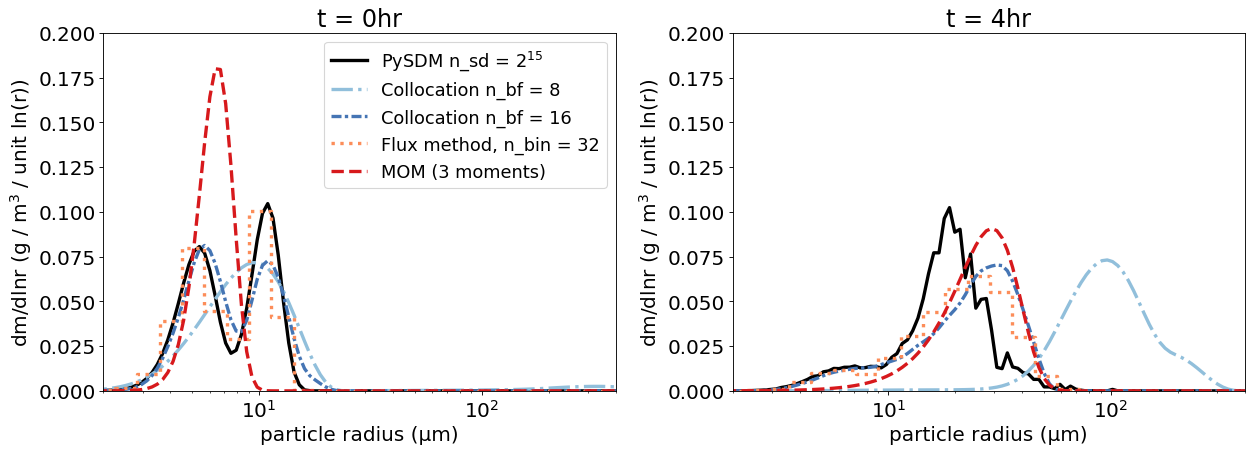

In [14]:
# plot all of them
pyplot.rcParams.update({'font.size':18})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

fig, ax = pyplot.subplots(nrows=1, ncols=2, figsize=(16,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM sdm_y1: m^3 / m^3 / (unit ln R) --> 1e6 g / m^3 / unit ln R
r_sdm = settings.radius_bins_edges[1:] / si.um
dlnr_sdm = np.log(r_sdm[2]) - np.log(r_sdm[1])

ax[0].plot(r_sdm, sdm_y1[:,0] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[1].plot(r_sdm, sdm_y1[:,-1] * 1e6, linestyle=ls[0], color=colors[0], label='PySDM n_sd = $2^{15}$', linewidth=3)


# COLLOCATION: (um^6 / cm^3) -> 
x = settings.volume_bins_edges[:-1]/si.um**3
yrbf8i = rbf8_i(x)
yrbf8f = rbf8_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf8i * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)#, label='Collocation n_bf = 8, init')
ax[1].plot(r_sdm, 3*x*x*yrbf8f * si.cm**3, linestyle=ls[1],color=colors[1], label='Collocation n_bf = 8',linewidth=3)
yrbf16i = rbf16_i(x)
yrbf16f = rbf16_f(x)
ax[0].plot(r_sdm, 3*x*x*yrbf16i * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)#, label='Collocation n_bf = 16, init')
ax[1].plot(r_sdm, 3*x*x*yrbf16f * si.cm**3, linestyle=ls[2],color=colors[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].step(r_grid_plt,
            gr_0 * si.cm**3,
            linestyle=ls[3],color=colors[3],label='Flux method, n_bin = 32', linewidth=3)#, label='Flux method, n_bin = 32, init')
ax[1].step(r_grid_plt,  
            gr_f * si.cm**3,
            linestyle=ls[3],color=colors[3], label='Flux method, n_bin = 32',linewidth=3)


# BULK: (um^3 / cm^3) / (um^3)
ymomi = mom_i(x)
ymomf = mom_f(x)
ax[0].plot(r_sdm, 3*x*x*ymomi * si.cm**3, linestyle=ls[4],color=colors[4],label="MOM (3 moments)",linewidth=3)#, label="MOM (3 moments), init")
ax[1].plot(r_sdm, 3*x*x*ymomf * si.cm**3, linestyle=ls[4],color=colors[4], label="MOM (3 moments)",linewidth=3)

ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel("particle radius (µm)")
#ax[0].set_ylabel("volume density µm$^3$/cm$^3$ per um$^3$")
ax[0].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[1].set_xlabel("particle radius (µm)")
ax[1].set_ylabel("dm/dlnr (g / m$^3$ / unit ln(r))")
ax[0].set_xlim([2.0, 400.0])
ax[1].set_xlim([2.0, 400.0])
ax[0].set_ylim([0.0, 0.2])
ax[1].set_ylim([0.0, 0.2])
ax[0].legend(fontsize=16)

ax[0].set_title('t = 0hr')
ax[1].set_title('t = 4hr')

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

#ax[0].grid()
#ax[1].grid()

pyplot.tight_layout()
pyplot.savefig("m(v)_golovin_bimodal.pdf", transparent=True)

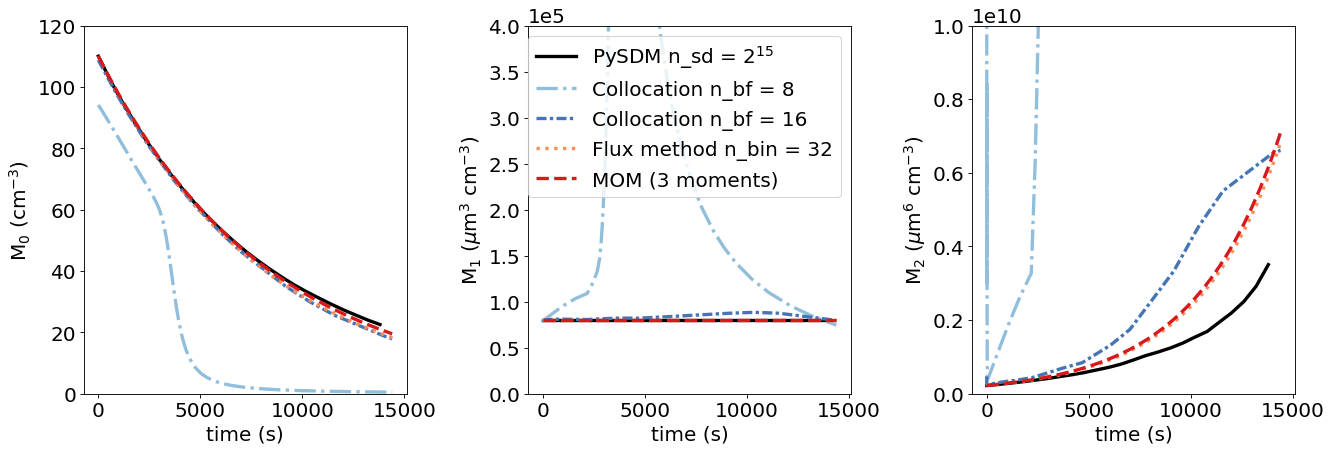

In [15]:
# plot all of them
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter()
xfmt.set_powerlimits((-3,3))  # Or whatever your limits are . . .

fig, ax = pyplot.subplots(nrows=1, ncols=3, figsize=(17,6), dpi=80, facecolor='w', edgecolor='k')

# PySDM:
ax[0].plot(times_sdm, mom0*si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
ax[1].plot(times_sdm, mom1 / si.um**3 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)
ax[2].plot(times_sdm, mom2 / si.um**6 * si.cm**3, color=colors[0],linestyle=ls[0], label='PySDM n_sd = $2^{15}$', linewidth=3)

# COLLOCATION:
ax[0].plot(col_8_times, col_8_M_0, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[1].plot(col_8_times, col_8_M_1, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)
ax[2].plot(col_8_times, col_8_M_2, color=colors[1],linestyle=ls[1], label='Collocation n_bf = 8',linewidth=3)

ax[0].plot(col_16_times, col_16_M_0, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[1].plot(col_16_times, col_16_M_1, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)
ax[2].plot(col_16_times, col_16_M_2, color=colors[2],linestyle=ls[2], label='Collocation n_bf = 16',linewidth=3)

# BIN: (mg / cm^3) / mg
ax[0].plot(t_bott, M0_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[1].plot(t_bott, M1_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)
ax[2].plot(t_bott, M2_bott, color=colors[3],linestyle=ls[3], label='Flux method n_bin = 32',linewidth=3)

# # BULK: (um^3 / cm^3) / (um^3)
ax[0].plot(t_cloudy, M0_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[1].plot(t_cloudy, M1_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)
ax[2].plot(t_cloudy, M2_cloudy, color=colors[4],linestyle=ls[4], label='MOM (3 moments)',linewidth=3)

ax[0].set_xlabel('time (s)')
ax[1].set_xlabel('time (s)')
ax[2].set_xlabel('time (s)')
ax[0].set_ylabel('M$_0$ (cm$^{-3}$)')
ax[1].set_ylabel('M$_1$ ($\mu$m$^3$ cm$^{-3}$)')
ax[2].set_ylabel('M$_2$ ($\mu$m$^6$ cm$^{-3}$)')
ax[0].set_ylim([0, 120])
ax[1].set_ylim([0, 4e5])
ax[2].set_ylim([0, 1e10])
ax[1].legend()
ax[1].yaxis.set_major_formatter(xfmt)

pyplot.tight_layout()
pyplot.savefig("moments_golovin_bimodal.pdf", transparent=True)


In [16]:
volume_cutoff = 4/3*np.pi*r_cutoff**3

In [17]:
t_precip_16 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_16 = [23.164628741239973, 2.438604347359927, 3.7635982054475225, 5.60595936581952, 7.984710898264256, 10.904003246677261, 14.35737732731293, 18.329333737541056, 22.798520682766988, 27.739674981632863, 33.12459409414247, 37.909384289627475, 43.66298019579381, 62.83503099171163, 24.89584094699513, 49.575016427653274, 75.84029609369823, 103.47858583230109, 132.28351117107138, 162.0594294883229, 192.62246884494834, 223.79999331607604, 255.4299612332953, 287.3609251846349, 319.45203201458287, 351.5730228240843, 383.60409092676304, 415.4353006101093, 446.967023849904, 478.108489367634, 508.7775969091663, 538.900917244741, 568.4136921689822, 597.270703575941, 625.4133292612826, 793.0431458124131, 1101.9167967019916, 1432.0024590334624, 1781.8852175733755, 2150.0716133954475, 2534.989643879647, 2934.9887627129337, 3348.345025559993, 3773.3773546240463, 4208.377359739029, 4651.631791874763, 5101.4560186730305, 5556.194024447913, 6014.218410185687, 6474.070135329572, 6934.423223289208, 7393.627066919427, 7850.094315966405, 8302.31574029406, 8748.860229883858, 9188.37479483484, 9940.202876585303, 10768.518234175279, 11619.595959295886, 12484.134323380738, 13354.740475790528, 14225.224444927197, 15088.95283367403, 15940.43570370055, 16798.967826254837, 17650.687782079374, 18492.26811626399, 19321.59435533479, 20136.694057432996, 20935.736812313473, 21717.034241347093, 22479.03999751897, 23220.35361718369, 23939.75910589309, 24636.206693140506, 25308.786272130383, 25956.727034089374, 26579.39746826564, 27176.3053619286, 27747.097800369564, 28291.532401519104, 28809.298563084893, 29300.493314631298, 29765.34369187234, 30204.118968635245, 30617.130656861496, 31004.73250660453, 31367.320506033248, 31705.332881428763, 32019.250097186443, 32309.594855814736, 32576.93209793596, 32821.86900228569, 33045.054985713345, 33247.18170318153, 33428.98304776686, 33591.235150658846, 33734.75546454817, 33860.14944937048, 33968.132826725545]

t_precip_8 = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_8 = [1004.6119111129144, 1144.7105109314034, 2300.971955140518, 3468.8369267359035, 4641.45493164755, 5812.205452144496, 6974.7547925657145, 8123.127437242113, 9251.769149229753, 10355.58565416779, 11429.984542106218, 12470.900036618144, 13474.792739953238, 14438.676527015317, 15360.100194577015, 16237.12088143014, 20839.892261414523, 27891.11735848464, 35872.13986973913, 47679.53389726637, 84503.65160093577, 156390.2818709088, 278660.8830272196, 457128.47846522107, 665794.4471383091, 850176.3943384226, 963023.2284616022, 996319.0820313048, 961672.3213697065, 897143.7792670693, 825943.7088836684, 755779.0821456594, 691299.4967004482, 633324.3435977941, 581919.3765204212, 536650.0295940054, 496702.1271009982, 461527.57101602433, 430333.2167796591, 402657.679990756, 377955.1657526077, 355840.67407521926, 335900.7317185011, 317987.0743689004, 301648.3767929347, 286878.1703784899, 273334.46588905173, 260907.10231225626, 249573.61778014674, 239062.6526748518, 229340.25109384093, 220402.06194822124, 212054.05661912452, 204261.51724162925, 197033.29275723943, 190279.19878265267, 183918.09542373364, 177949.98268046338, 172377.25664707035, 167110.05145729787, 162125.32277700346, 157423.07060618736, 153000.05503327944, 148791.47874678212, 144790.51491876142, 140997.163549213, 137417.86161077645, 133988.97179530837, 130707.12704627286, 127572.32736367431, 124584.57274751016, 121749.64786349644, 119033.5561127472, 116420.06331402685, 113909.16946733484, 111500.87457267215, 109195.17863003562, 107000.59308284699, 104879.89413613333, 102829.29411426038, 100848.79301723308, 98938.39084505496, 97098.0875977177, 95327.88327522777, 93633.46229428393, 91994.96485749685, 90403.99210762896, 88860.54404468462, 87364.62066865739, 85916.22197955051, 84515.34797736313, 83161.99866209686, 81859.36521500917, 80592.83763658175, 79359.67065522948, 78159.86427095057, 76993.41848374654, 75860.33329361588, 74760.60870056391, 73694.24470458574]


In [18]:
t_precip_mom = [0.0, 145.45454545454547, 290.90909090909093, 436.3636363636364, 581.8181818181819, 727.2727272727273, 872.7272727272727, 1018.1818181818181, 1163.6363636363637, 1309.090909090909, 1454.5454545454545, 1600.0, 1745.4545454545455, 1890.909090909091, 2036.3636363636363, 2181.818181818182, 2327.2727272727275, 2472.7272727272725, 2618.181818181818, 2763.6363636363635, 2909.090909090909, 3054.5454545454545, 3200.0, 3345.4545454545455, 3490.909090909091, 3636.3636363636365, 3781.818181818182, 3927.2727272727275, 4072.7272727272725, 4218.181818181818, 4363.636363636364, 4509.090909090909, 4654.545454545455, 4800.0, 4945.454545454545, 5090.909090909091, 5236.363636363636, 5381.818181818182, 5527.272727272727, 5672.727272727273, 5818.181818181818, 5963.636363636364, 6109.090909090909, 6254.545454545455, 6400.0, 6545.454545454545, 6690.909090909091, 6836.363636363636, 6981.818181818182, 7127.272727272727, 7272.727272727273, 7418.181818181818, 7563.636363636364, 7709.090909090909, 7854.545454545455, 8000.0, 8145.454545454545, 8290.90909090909, 8436.363636363636, 8581.818181818182, 8727.272727272728, 8872.727272727272, 9018.181818181818, 9163.636363636364, 9309.09090909091, 9454.545454545454, 9600.0, 9745.454545454546, 9890.90909090909, 10036.363636363636, 10181.818181818182, 10327.272727272728, 10472.727272727272, 10618.181818181818, 10763.636363636364, 10909.09090909091, 11054.545454545454, 11200.0, 11345.454545454546, 11490.90909090909, 11636.363636363636, 11781.818181818182, 11927.272727272728, 12072.727272727272, 12218.181818181818, 12363.636363636364, 12509.09090909091, 12654.545454545454, 12800.0, 12945.454545454546, 13090.90909090909, 13236.363636363636, 13381.818181818182, 13527.272727272728, 13672.727272727272, 13818.181818181818, 13963.636363636364, 14109.09090909091, 14254.545454545454, 14400.0]
m_precip_mom = [5.8939020604571585e-9, 2.0050770160168598e-8, 6.466028414537871e-8, 1.9817328764658288e-7, 5.786481186400115e-7, 1.6134264937831255e-6, 4.305248636198427e-6, 1.1016919663144346e-5, 2.708855709435736e-5, 6.411821753213197e-5, 0.0001463561463685691, 0.0003227000312037973, 0.0006883873772267088, 0.0014228691451109938, 0.0028537406305263508, 0.005561215402580749, 0.010543613540815828, 0.019471748940073495, 0.035068825318415375, 0.06166214072088166, 0.10596297681799678, 0.17814057233516406, 0.29326403501296494, 0.4731909432408995, 0.7489820066706032, 1.1639161814532109, 1.777168514296344, 2.6681942719762612, 3.9418354894924086, 5.734132485363955, 8.218783930613705, 11.614153170032063, 16.19067657489349, 22.27848314721768, 30.27499398671402, 40.65224426343683, 53.96363552327906, 70.84982695955439, 92.04347489740024, 118.37252865756007, 150.76185414440266, 190.23296453494305, 237.90169937677885, 294.97378842224373, 362.73822667739415, 442.5585352073966, 535.8620263597564, 644.1271770449738, 768.8694283405225, 911.6256328795863, 1073.937430005359, 1257.334012824419, 1463.3144808154439, 1693.33023157996, 1948.7677983559895, 2230.93225274537, 2541.0317113659935, 2880.163140277654, 3249.2995081498198, 3649.27882934597, 4080.7949117286735, 4544.389986474309, 5040.449525088773, 5569.198768798207, 6130.701340378244, 6724.859864307448, 7351.418038572678, 8009.964667160303, 8699.939147044557, 9420.63805926546, 10171.223349793514, 10950.731175408613, 11758.081608213575, 12592.089299412864, 13451.474128043732, 14334.872452829442, 15240.848649265286, 16167.906153346268, 17114.498903555108, 18079.042344510064, 19059.923840139527, 20055.51320834783, 21064.172231106044, 22084.263763562798, 23114.16057273498, 24152.252922806838, 25196.955934208552, 26246.71634910143, 27300.018073683736, 28355.387685532827, 29411.398959524544, 30466.676578063016, 31519.899786745515, 32569.80485653554, 33615.187242273736, 34654.9035011996, 35687.8721008983, 36713.07426882053, 37729.55441449878, 38736.419762123754]


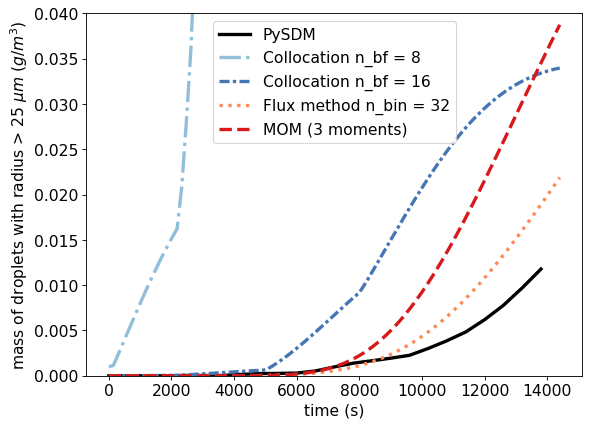

In [19]:
# plot all of them
pyplot.rcParams.update({'font.size':14})
colors = ['#000000','#91bfdb','#4575b4','#fc8d59','#d7191c']
ls = ['-','dashdot',(0, (3, 1, 1, 1)),'dotted','dashed']

pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
pyplot.plot(times_sdm, sdm_precip[:] / 1e6, color=colors[0],linestyle=ls[0], label='PySDM', linewidth=3)
pyplot.plot(t_precip_8, np.divide(m_precip_8, 1e6), color=colors[1], linestyle=ls[1],label='Collocation n_bf = 8',linewidth=3)
pyplot.plot(t_precip_16, np.divide(m_precip_16, 1e6), color=colors[2], linestyle=ls[2],label='Collocation n_bf = 16',linewidth=3)
pyplot.plot(t_bott, np.divide(mprecip_bin, 1e6), color=colors[3], linestyle=ls[3],label='Flux method n_bin = 32',linewidth=3)
pyplot.plot(t_precip_mom, np.divide(m_precip_mom, 1e6), color=colors[4], linestyle=ls[4],label='MOM (3 moments)',linewidth=3)
pyplot.xlabel('time (s)')
pyplot.ylabel('mass of droplets with radius > 25 $\mu m$ $(g / m^3)$')
pyplot.legend()
pyplot.gca().yaxis.set_major_formatter(xfmt)
pyplot.gca().set_ylim([0.0, 0.04])
pyplot.savefig('m_precip_golovin_bimodal.pdf', transparent=True)

## Error Computation

In [21]:
import pickle

def compute_L2_error(y1, y2):
    return np.linalg.norm(y1-y2)/np.linalg.norm(y2)

def bott_m_f(x):
    mf = np.zeros(len(x))
    dlnr_bin = np.mean(np.log(r_grid[2:]) - np.log(r_grid[1:-1]))
    for i in range(len(x)):
        i0 = find_nearest(v_grid,x[i])[0]
        mf[i] = gr_f[i0]#/dlnr_bin*dlnr
    return mf

v_sdm = x

yrbf8f = rbf8_f(v_sdm)
e8f = compute_L2_error(3*yrbf8f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

yrbf16f = rbf16_f(v_sdm)
e16f = compute_L2_error(3*yrbf16f*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ymomf = mom_f(v_sdm)
emomf = compute_L2_error(3*ymomf*v_sdm*v_sdm*1e-6, sdm_y1[:,-1]*1e6)

ybinf = bott_m_f(v_sdm)
ebinf = compute_L2_error(ybinf*1e-6, sdm_y1[:,-1]*1e6)

print(e8f,e16f,emomf,ebinf)
errs = [e8f, e16f, emomf, ebinf]
pickle.dump(errs, open("golovin_bimodal_errors.pkl", "wb" ))

1.3521861874593608 0.64921524694726 0.7359742225533554 0.5621605260412045


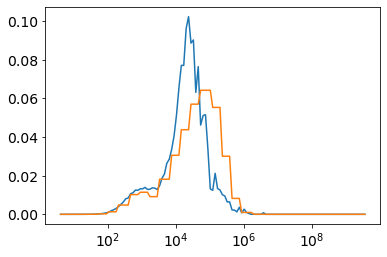

In [23]:
pyplot.plot(v_sdm, 1e6*sdm_y1[:,-1])
pyplot.plot(v_sdm, 1e-6*ybinf)
pyplot.xscale('log')